<a href="https://colab.research.google.com/github/NILodio/EACD-MONOGRAFIA/blob/master/01_MONOGRAFIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [11]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
import uuid
import json
import tensorflow as tf

# Loading the Data
We have to write a load_data function that load the images and the labels from the folder.

In [12]:
from local.lib import load_data as dt
dic = {'Formato_1': 1, 'Formato_2': 2, 'Formato_3': 3}

In [13]:
Data = dt.create_and_read_metadata(images_path=  'local/data/imgs' ,medata_path= 'local/data',split_value= 0.7 , labels_dic=dic)

In [14]:
Train , Test = (Data[Data['split'] == 'train'] , Data[Data['split'] != 'train'] )

# Let's explore the dataset

1. How many training and testing examples do we have ?
2. What is the size of the images ?
3. What is the proportion of each observed category ?

In [15]:
n_train = Train.shape[0]
n_test = Test.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))


Number of training examples: 261
Number of testing examples: 134


<AxesSubplot:>

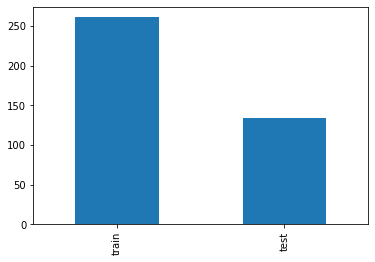

In [16]:
Data['split'].value_counts().plot(kind='bar')

In [17]:
Train.head(5)

,names,xmin,xmax,ymin,ymax,split,label
0,09-22-2020-14.53.24(1).jpg,0.137416,0.279979,0.394874,0.420505,train,1
1,09-22-2020-14.53.24(10).jpg,0.153446,0.291938,0.391390,0.415141,train,1
2,09-22-2020-14.53.24(100).jpg,0.142093,0.296076,0.380736,0.406633,train,1
4,09-22-2020-14.53.24(102).jpg,0.137374,0.289899,0.372496,0.402928,train,1
6,09-22-2020-14.53.24(104).jpg,0.128908,0.293472,0.375156,0.408504,train,1


### Let's explore the dataset with label == 1


In [18]:
Train[Train['label'] == 1].describe()

,xmin,xmax,ymin,ymax,label
count,136.000000,136.000000,136.000000,136.000000,136.0
mean,0.139390,0.287146,0.386539,0.413561,1.0
std,0.055271,0.055381,0.024567,0.024105,0.0
min,0.000688,0.120358,0.276580,0.301790,1.0
25%,0.133376,0.278218,0.379508,0.405804,1.0
50%,0.139593,0.286585,0.385909,0.413408,1.0
75%,0.147026,0.295635,0.393429,0.420696,1.0
max,0.708696,0.863478,0.594419,0.618430,1.0


<AxesSubplot:>

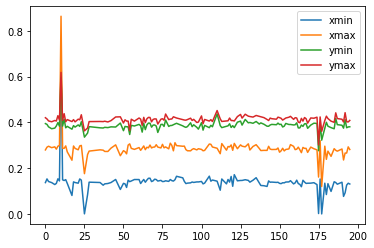

In [19]:
Train[['xmin','xmax','ymin','ymax']][Train['label'] == 1].plot()

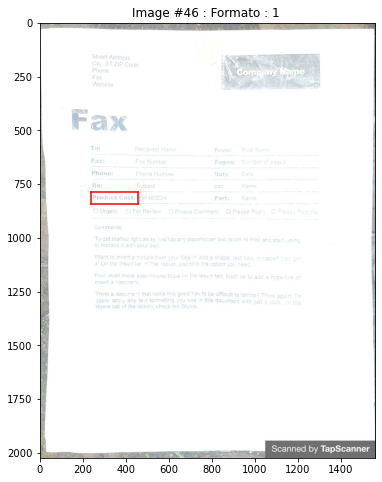

In [30]:
from local.lib import F_Plots as MyPlot
import importlib 
importlib.reload(MyPlot) 
MyPlot.display_random_image(Train,1,True)

# Split Data

In [31]:
from local.lib import tf_DataSet as My_tf

train_sources = My_tf.build_sources_from_metadata(Data[Data['label'] == 1])
test_sources = My_tf.build_sources_from_metadata(Data[Data['label'] == 1], mode='test')


# Tensorflow DataSet

In [32]:
tf_dataset = My_tf.make_tf_dataset(train_sources, training=False,
    batch_size=3, num_epochs=1,
    num_parallel_calls=3)

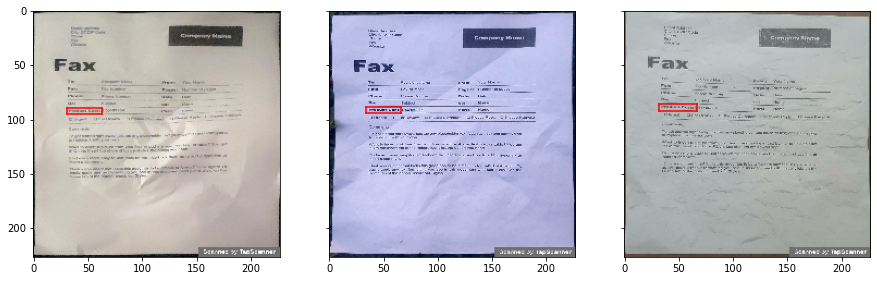

In [33]:
dataset = iter(tf_dataset)
MyPlot.imshow_batch_of_three(next(dataset))

## ModeloS

In [34]:
# Define a simple sequential model

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', input_shape=(227,227,3)))
model.add(tf.keras.layers.AveragePooling2D())

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='tanh'))
model.add(tf.keras.layers.AveragePooling2D())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=120, activation='tanh'))

model.add(tf.keras.layers.Dense(units=84, activation='tanh'))

model.add(tf.keras.layers.Dense(units=4, activation = 'sigmoid'))
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(0.0001))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 223, 223, 6)       456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 111, 111, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 16)      2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 53, 53, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 44944)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               5393400   
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [35]:
Data_train = My_tf.make_tf_dataset(train_sources, training=True,
    batch_size=4, num_epochs=1,
    num_parallel_calls=2)

Data_test = My_tf.make_tf_dataset(test_sources, training=True,
    batch_size=1, num_epochs=1,
    num_parallel_calls=2)

In [36]:
print(model.evaluate(Data_train))

34/34 [==============================] - 4s 114ms/step - loss: 0.0707
0.07068749495288905


In [37]:
h = model.fit(x=Data_train, epochs=10,validation_data=Data_test, validation_steps=1)

Train for 34 steps, validate for 1 steps
Epoch 1/10
34/34 [==============================] - 1s 38ms/step - loss: 0.0087 - val_loss: 0.0040
Epoch 2/10
34/34 [==============================] - 1s 27ms/step - loss: 0.0062 - val_loss: 0.0039
Epoch 3/10
34/34 [==============================] - 1s 28ms/step - loss: 0.0061 - val_loss: 0.0050
Epoch 4/10
34/34 [==============================] - 1s 28ms/step - loss: 0.0057 - val_loss: 0.0032
Epoch 5/10
34/34 [==============================] - 1s 28ms/step - loss: 0.0049 - val_loss: 0.0020
Epoch 6/10
34/34 [==============================] - 1s 28ms/step - loss: 0.0028 - val_loss: 1.3492e-04
Epoch 7/10
34/34 [==============================] - 1s 28ms/step - loss: 0.0019 - val_loss: 7.0982e-04
Epoch 8/10
34/34 [==============================] - 1s 28ms/step - loss: 0.0020 - val_loss: 6.0224e-05
Epoch 9/10
34/34 [==============================] - 1s 29ms/step - loss: 0.0019 - val_loss: 1.3363e-05
Epoch 10/10
34/34 [==============================] -

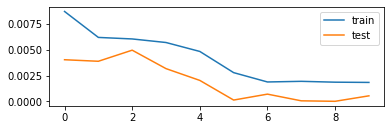

In [38]:
plt.subplot(2,1,1)
plt.plot(h.history['loss'],label='train')
plt.plot(h.history['val_loss'],label='test')
plt.legend()

In [39]:
predictions= model.predict(Data_test)
predictions_list=predictions.tolist()
imgs,b,a= zip(*test_sources)
sources= [r for r in zip(imgs,predictions_list,a)]


In [40]:
Example_Data = My_tf.make_tf_dataset(sources, training=False,
    batch_size=3, num_epochs=1,
    num_parallel_calls=3)

Data_plt = iter(Example_Data)

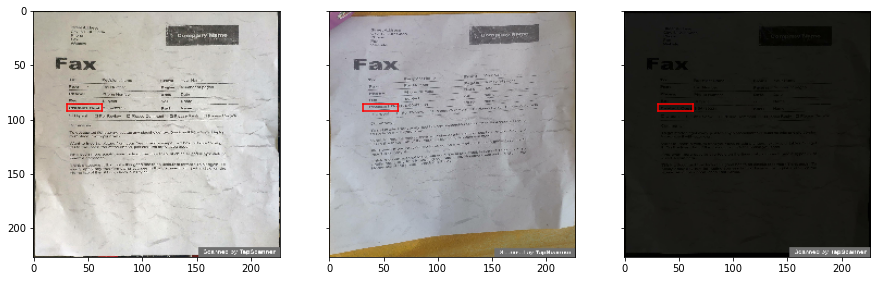

In [41]:
MyPlot.imshow_batch_of_three(next(Data_plt),show_box=True)

In [63]:
Prueba_Test_IoU

,names,xmin,xmax,ymin,ymax,split,label
3,09-22-2020-14.53.24(101).jpg,0.132850,0.283092,0.381750,0.409683,test,1
5,09-22-2020-14.53.24(103).jpg,0.151140,0.323092,0.378483,0.401411,test,1
15,09-22-2020-14.53.24(112).jpg,0.140741,0.284900,0.382467,0.413838,test,1
16,09-22-2020-14.53.24(113).jpg,0.137475,0.295440,0.384459,0.407313,test,1
20,09-22-2020-14.53.24(117).jpg,0.090974,0.244492,0.378631,0.403527,test,1
...,...,...,...,...,...,...,...
182,09-22-2020-14.53.24(86).jpg,0.134557,0.275994,0.407702,0.432152,test,1
184,09-22-2020-14.53.24(88).jpg,0.177133,0.322275,0.394989,0.424146,test,1
188,09-22-2020-14.53.24(91).jpg,0.127329,0.273292,0.395227,0.421117,test,1
189,09-22-2020-14.53.24(92).jpg,0.093075,0.248199,0.404811,0.434674,test,1


In [114]:
Prueba_Test_IoU.iloc[0].values[1:5]

array([0.13285024154589373, 0.28309178743961355, 0.3817504655493482,
       0.40968342644320294], dtype=object)

In [115]:
predictions[0]

array([0.13754241, 0.2788484 , 0.38091695, 0.4064735 ], dtype=float32)

In [67]:
predictions[1][0]

0.13747664

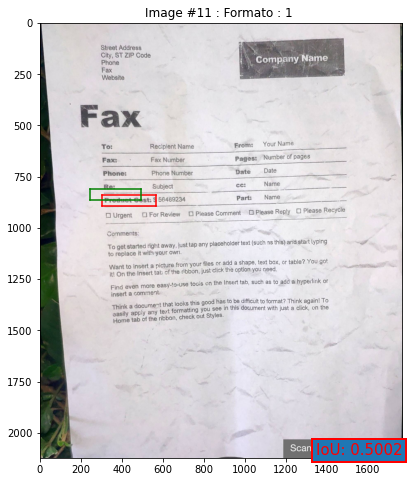

In [146]:
from local.lib import F_Plots as MyPlot
from local.lib import IoU as P
import importlib 
importlib.reload(MyPlot)
importlib.reload(P)

MyPlot.display_random_image_Pre(Prueba_Test_IoU,predictions)

# IoU

## Examples 

In [48]:
from collections import namedtuple
import numpy as np


Prueba = Test[Test['label'] == 1]['names']
Detection = namedtuple("Detection", ["image_path", "gt", "pred"])

Examples = []

for i in range(len(Prueba)):
    Examples.append(Detection(os.path.join('local\data\imgs',Prueba.iloc[i]),Prueba_Test_IoU[i] , predictions[i]))


In [49]:
for i in Examples[0:5]:
    print(tuple(i.gt[:2]))

(0.13285024154589373, 0.28309178743961355)
(0.15113974231912786, 0.3230921704658077)
(0.14074074074074075, 0.2849002849002849)
(0.13747521480502314, 0.29543952412425645)
(0.09097370291400142, 0.24449182658137886)


In [57]:
[['xmin','xmax','ymin','ymax']]

[['xmin', 'xmax', 'ymin', 'ymax']]

In [ ]:
# loop over the example detections
for detection in examples:
	# load the image
	image = cv2.imread(detection.image_path)
	# draw the ground-truth bounding box along with the predicted
	# bounding box
	cv2.rectangle(image, tuple(detection.gt[:2]), 
		tuple(detection.gt[2:]), (0, 255, 0), 2)
	cv2.rectangle(image, tuple(detection.pred[:2]), 
		tuple(detection.pred[2:]), (0, 0, 255), 2)
	# compute the intersection over union and display it
	iou = bb_intersection_over_union(detection.gt, detection.pred)
	cv2.putText(image, "IoU: {:.4f}".format(iou), (10, 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
	print("{}: {:.4f}".format(detection.image_path, iou))
	# show the output image
	cv2.imshow("Image", image)
	cv2.waitKey(0)